Microsoft Differential Privacy Whitepaper Collateral Notebooks Part 2
# Privacy Preserving Machine Learning with Differential Privacy 

The goal of this notebook is to demonstrate how to perform supervised machine learning on a tabular data with differential privacy. This ensures that the contribution of the individuals' data to the resulting machine learning model is masked out. Consequently it is not possible that information of individuals  may be leaked from the trained machine learning model.
Furthermore, our objective is to assess the impact of tha data set size and its complexity on resulting privacy levels and accuracy of the machine learning model. 



We are generating a synthetic dataset to control dataset size and difficulty of the classification problem. The flow of the demonstration is as follows:
1. Generate datset for the supervised classification problem
2. Train a Random Forest classifier in a standard (non-private) fashion as benchmark for maximum achievable classification performance
5. **Todo**: Transform the original non-private dataset in a differential private dataset using 'Whitenoise'

## Setup
### Installs and imports

In [1]:
# !pip install --upgrade pandas

In [3]:
# Installs
#!pip install opendp.whitenoise as wn

# Imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

## Generate dataset for supervised classification problem
We are using the `make_classification` function from Scikit Learn to generate a synthetic dataset as starting point. While it is not a real world dataset, the approach has the advantage that the characteristics of the data (e.g. number of features, classes, noise, amount of mislabeled instances and classification dificulty) can be controlled.

Our dataset has the following characteristics:

- 100,000 instances, 10 classes
- 20 ordinal features: mixture of relevant ('informative'), redundant, repeated and pure noise
- 3% of instances are mislabeled

In [6]:
n_samples = 10000 # 100000
n_features = 7
n_informative = 7 # relevant features to explain target
n_redundant = 0 # linear combinations of informative
n_repeated = 0 # random copies of informative and redundant
n_useless = n_features - n_informative - n_redundant - n_repeated # noise

n_classes = 10
seed = 1

In [7]:
# define feature names
def feature_names (n_items, prefix = 'feature'):
    names = []
    for i in range(n_items):
        names.append(prefix + '_' + str(i))
    return names

inf_features = feature_names(n_informative, 'inf')
red_features = feature_names(n_redundant, 'red')
rep_features = feature_names(n_repeated, 'rep')
useless_features = feature_names(n_useless, 'noise')

feature_names = inf_features + red_features + rep_features + useless_features

X, y = make_classification(n_samples=n_samples, 
                    n_features=n_features, 
                    n_informative=n_informative, 
                    n_redundant=n_redundant, 
                    n_repeated=n_repeated, 
                    n_classes=n_classes, 
                    n_clusters_per_class=2, 
                    weights=None, 
                    flip_y=0.03, 
                    class_sep=5.0, 
                    hypercube=True, 
                    shift=15.0, # 20
                    scale=0.5, # 2.0
                    shuffle=False, 
                    random_state=seed)

### Convert features to integer values

In [8]:
# Convert to Dataframe
Z=np.zeros((X.shape[0], X.shape[1]+1))
Z[:,:-1]=X
Z[:,-1]=y

columns = feature_names + ['class']
df = pd.DataFrame(Z, columns=columns)

# convert to integer if needed for WhiteNoise dataset synthesizer
df = df.astype('int32')

df.head()

,inf_0,inf_1,inf_2,inf_3,inf_4,inf_5,inf_6,class
0,9,10,10,10,4,4,8,0
1,9,10,10,10,5,4,9,0
2,10,10,10,9,4,5,11,0
3,9,9,9,10,4,5,9,0
4,10,9,9,10,4,4,9,0


### Review pairs of selected features for an intuition of the classification difficulty

<Figure size 640x480 with 0 Axes>

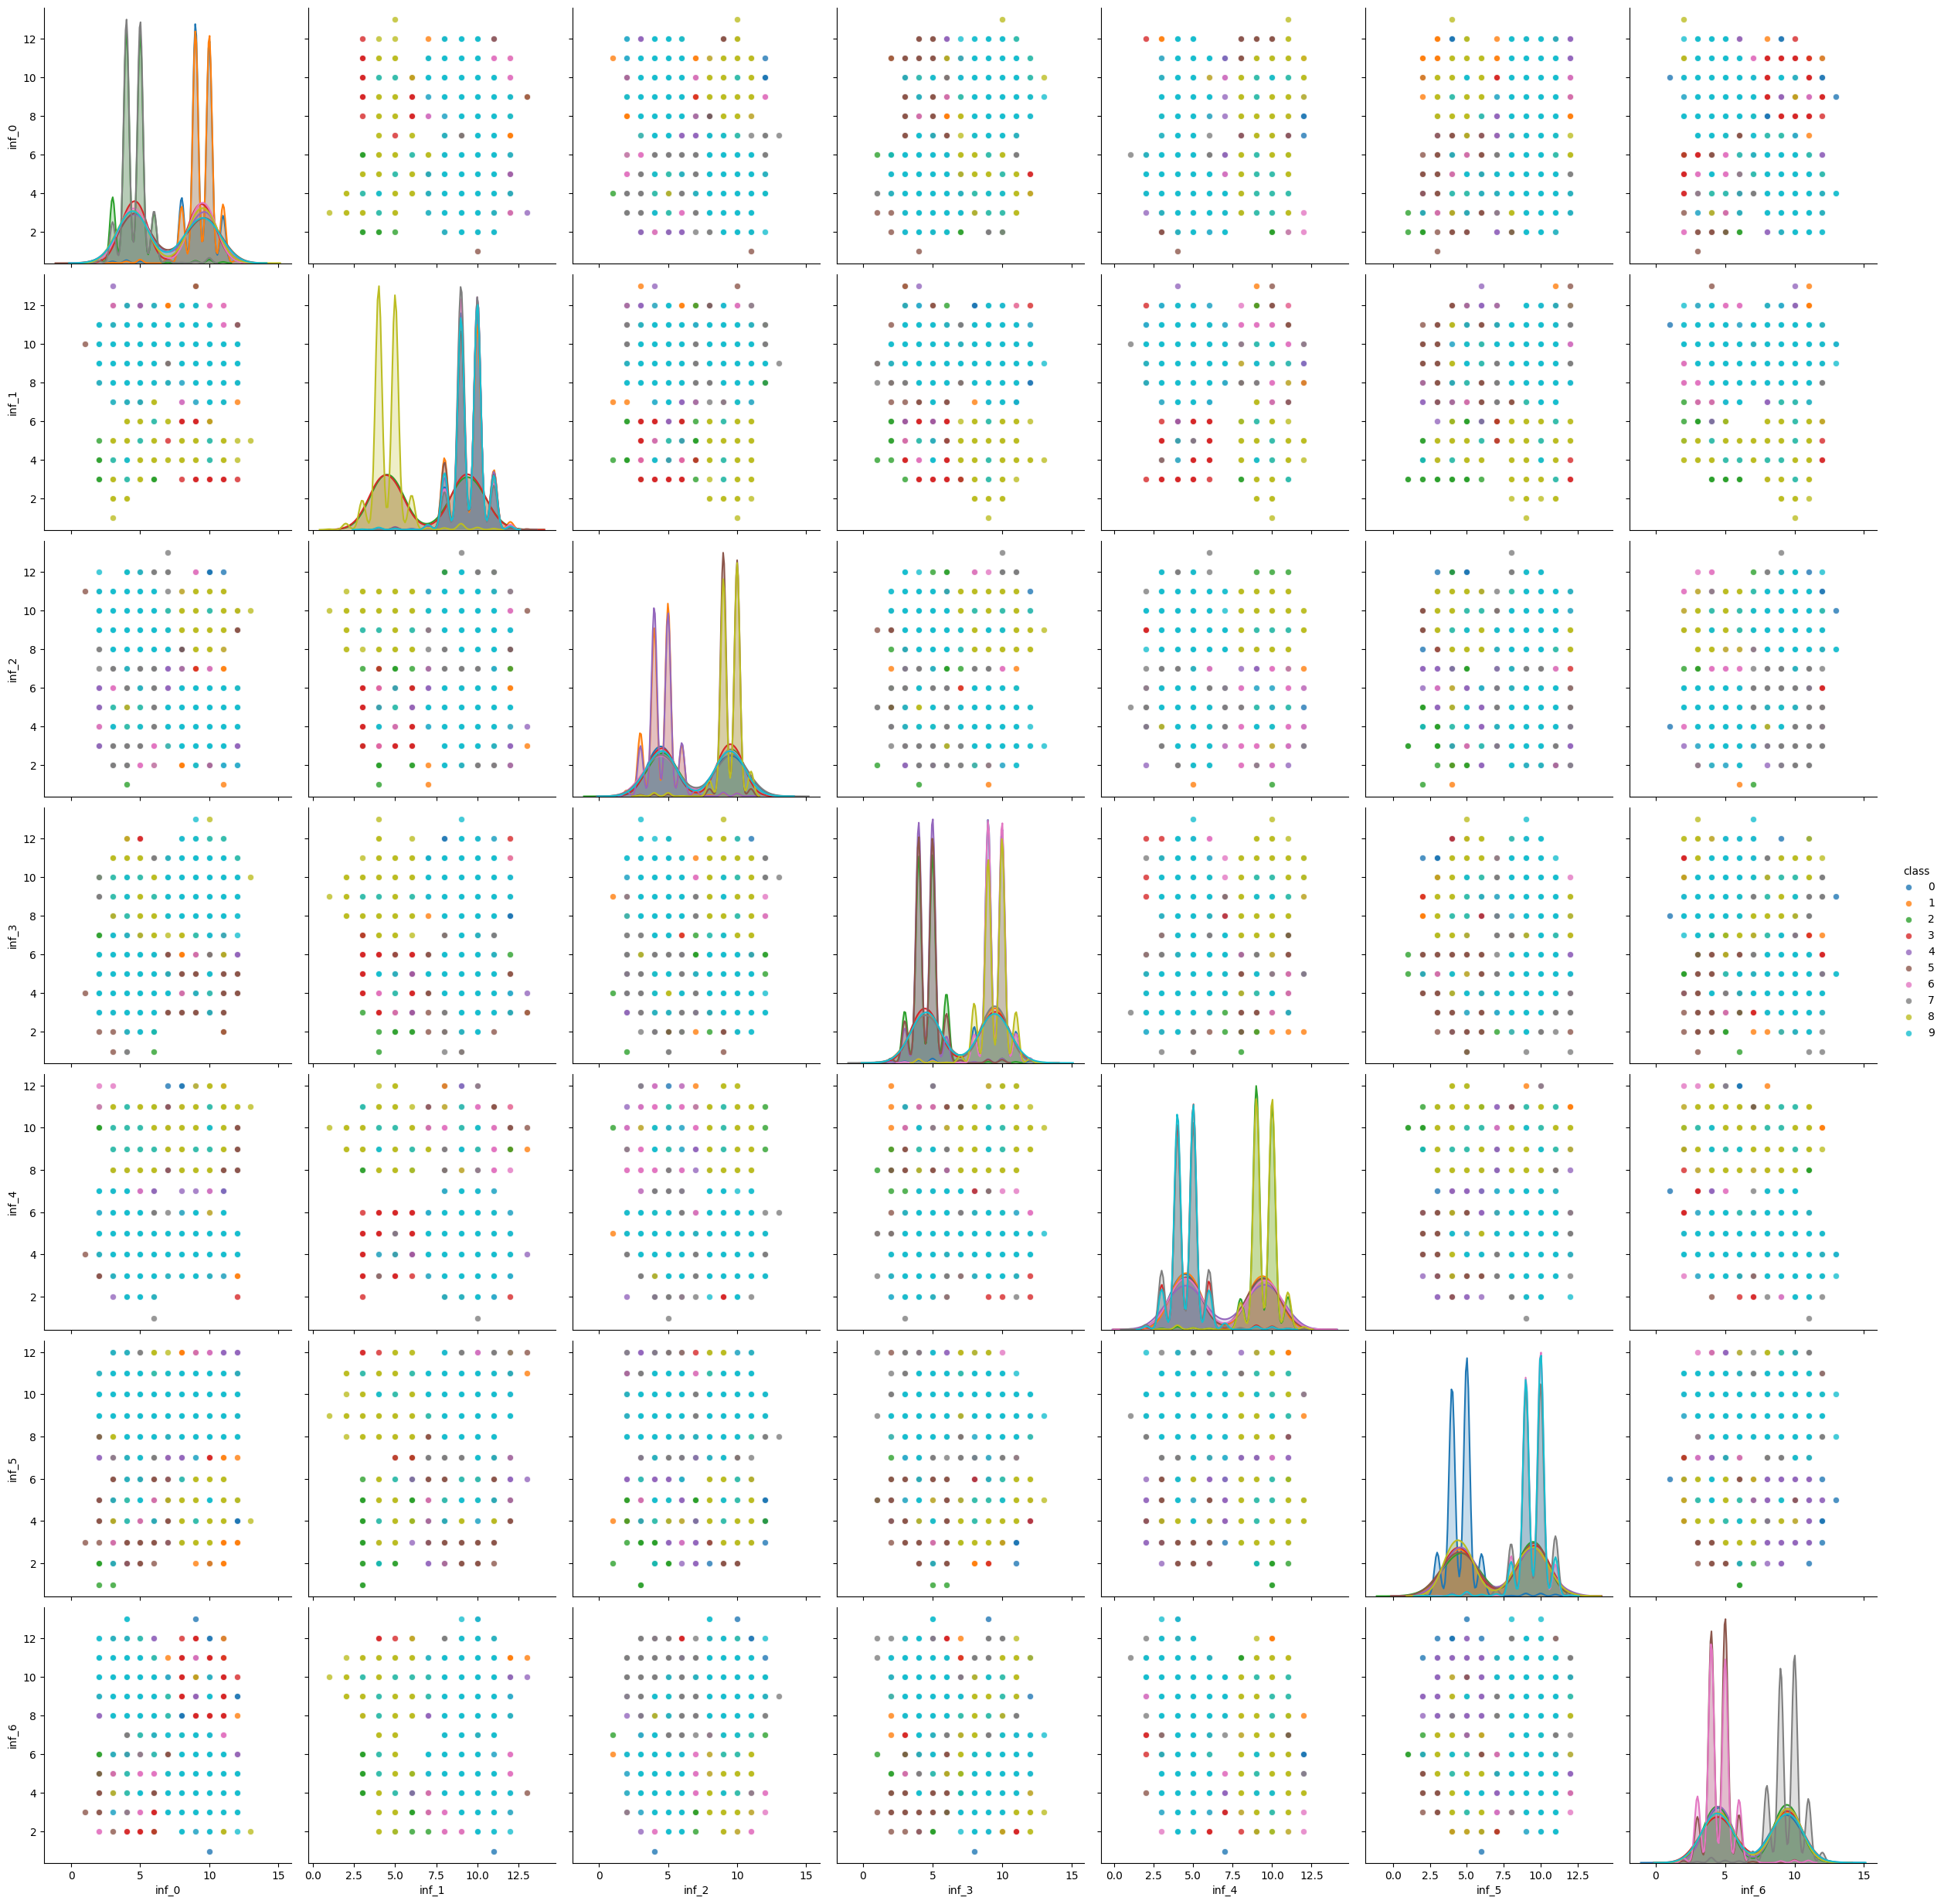

In [6]:
plot_features = inf_features

plt.rcParams.update(plt.rcParamsDefault)
plt.clf()
g = sns.pairplot(df, vars=plot_features, height=3.5, hue='class', plot_kws=dict(alpha=0.8))
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['class'],axis=1), df['class'], test_size=0.2, stratify = df['class'], random_state = seed)

## Train a Random Forest classifier in a standard (non-private) fashion as benchmark
We are choosing a Random Forest for our baseline since this classifier typically have a strong performance and therefore should indicate the upper bound of achievable classification metrics for the given dataset. Since 3% of the instances are mislabeled, the maximum achievable accuracy level should be around 97%.

In [8]:
np.random.seed(seed)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.96      0.96      0.96       200
           2       0.95      0.98      0.97       198
           3       0.98      0.97      0.97       200
           4       0.96      0.93      0.95       200
           5       0.97      0.96      0.97       201
           6       0.95      0.96      0.96       198
           7       0.96      0.98      0.97       201
           8       0.98      0.97      0.98       200
           9       0.97      0.97      0.97       202

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



## Transform the original non-private dataset in a differential private dataset using 'Whitenoise'
(work in progress)

### Combine features and labels for synthesizer

In [9]:
Xy_train = pd.concat([X_train, y_train], axis = 1)

Xy_train.head()

,inf_0,inf_1,inf_2,inf_3,inf_4,inf_5,inf_6,class
8509,4,9,9,10,4,10,8,7
9633,9,9,4,10,4,10,4,9
544,9,9,4,9,5,4,4,1
9836,11,9,4,9,5,9,5,9
3465,9,11,11,8,4,9,3,6


### Fit MWEM dataset synthesizer 

In [10]:
%%time

from opendp.whitenoise.synthesizers.mwem import MWEMSynthesizer # current mwem.py taken from WN Github

synth = MWEMSynthesizer(Q_count = 400,
                        epsilon = 10.0,
                        iterations = 60,
                        mult_weights_iterations = 40,
                        splits = [],
                        split_factor = 1,
                        max_bin_count = 500,
                        custom_bin_count = {})
                        
synth.fit(Xy_train)

Initializing iteration with columns [0]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [1]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [2]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [3]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [4]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [5]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [6]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [7]
Estimate duration till completion: 0.0 seconds (lower bound)
CPU times: user 15.2 s, sys: 0 ns, total: 15.2 s
Wall time: 15.2 s


### Sample differentially private dataset

In [11]:
%%time

sample_size = Xy_train.shape[0]

synthetic = synth.sample(int(sample_size))

# Convert to dataframe
synth_df = pd.DataFrame(synthetic, columns=Xy_train.columns)

# synth_df.to_csv('data/synthetic-dataset-MWEM_v2.csv')

CPU times: user 1.45 s, sys: 31.2 ms, total: 1.48 s
Wall time: 1.46 s


### Compare descriptive statistics of both datasets 

In [12]:
# Original dataset
Xy_train.describe()

,inf_0,inf_1,inf_2,inf_3,inf_4,inf_5,inf_6,class
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.00000,8000.000000
mean,7.014250,8.492500,7.024500,7.010875,6.74975,7.501125,6.72025,4.506625
std,2.641149,2.166052,2.636099,2.619468,2.60110,2.585118,2.62104,2.874672
min,2.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,0.000000
25%,5.000000,8.000000,5.000000,5.000000,4.00000,5.000000,4.00000,2.000000
50%,7.000000,9.000000,7.000000,7.000000,5.00000,9.000000,6.00000,5.000000
75%,10.000000,10.000000,10.000000,10.000000,9.00000,10.000000,9.00000,7.000000
max,13.000000,13.000000,13.000000,13.000000,12.00000,12.000000,13.00000,9.000000


In [13]:
# DP version of dataset
synth_df.describe()

,inf_0,inf_1,inf_2,inf_3,inf_4,inf_5,inf_6,class
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,7.814375,8.082875,6.936250,7.107125,6.751500,7.295750,6.550000,4.286000
std,3.003297,2.962154,2.721325,3.167673,2.725881,2.691085,2.757073,2.870015
min,4.000000,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000
25%,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000
50%,8.000000,9.000000,7.000000,7.000000,6.000000,9.000000,6.000000,4.000000
75%,10.000000,10.000000,9.000000,9.000000,9.000000,10.000000,9.000000,7.000000
max,13.000000,13.000000,11.000000,13.000000,11.000000,11.000000,11.000000,9.000000


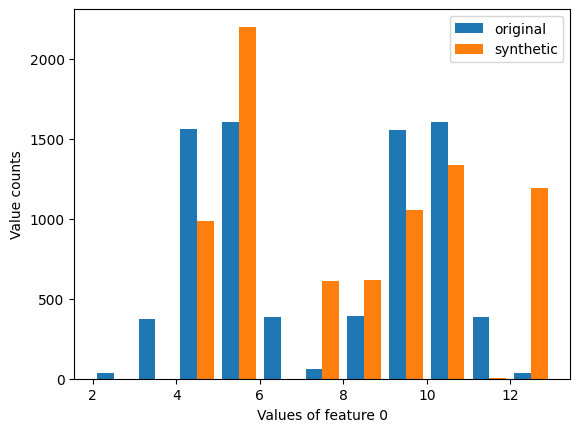

In [14]:
plt.hist((Xy_train['inf_0'], synth_df['inf_0']), label = ('original', 'synthetic'), bins=11)

plt.xlabel('Values of feature 0')
plt.ylabel('Value counts')
plt.legend(loc='upper right')

plt.show()

### Train on synthetic dataset, test on 

In [15]:
X_train_dp = synth_df.drop('class', axis = 1)
y_train_dp = synth_df['class']

In [16]:
np.random.seed(seed)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train_dp, y_train_dp)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.11      0.20      0.14       200
           1       0.10      0.04      0.06       200
           2       0.09      0.13      0.11       198
           3       0.07      0.04      0.05       200
           4       0.09      0.06      0.07       200
           5       0.10      0.11      0.11       201
           6       0.12      0.20      0.15       198
           7       0.13      0.10      0.12       201
           8       0.03      0.04      0.03       200
           9       0.06      0.02      0.03       202

    accuracy                           0.09      2000
   macro avg       0.09      0.09      0.09      2000
weighted avg       0.09      0.09      0.09      2000



## Diffprivlib LogReg
Clearly this classification task, with 9 categories, is too difficult for MWEM. I want a vanilla DP ML model baseline, so I try with diffprivlibs logreg. 

In [32]:
from diffprivlib.models import LogisticRegression as DPLR
clf = DPLR(epsilon=3.0).fit(X_train, y_train)
predictions = clf.predict(X_test)
print('DPLR Acc:' + str(classification_report(predictions, y_test)))
print('DPLR Acc:' + str(accuracy_score(predictions, y_test)))

/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/diffprivlib/models/logistic_regression.py:222: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


DPLR Acc:              precision    recall  f1-score   support

           0       0.42      0.45      0.44       185
           1       0.17      0.19      0.18       178
           2       0.51      0.55      0.53       185
           3       0.21      0.15      0.18       274
           4       0.15      0.32      0.20        94
           5       0.77      0.68      0.72       227
           6       0.38      0.42      0.40       183
           7       0.64      0.43      0.51       300
           8       0.49      0.63      0.55       155
           9       0.20      0.19      0.19       219

    accuracy                           0.39      2000
   macro avg       0.39      0.40      0.39      2000
weighted avg       0.42      0.39      0.40      2000

DPLR Acc:0.3945


In [35]:
from diffprivlib.models import GaussianNB as DPNB
clf = DPNB(epsilon=3.0).fit(X_train, y_train)
predictions = clf.predict(X_test)
print('DPLR Acc:' + str(classification_report(predictions, y_test)))
print('DPLR Acc:' + str(accuracy_score(predictions, y_test)))

NameError: name 'X_train' is not defined

## DP NN
We try my implementation of sklearns simple MLP using DP engine from pytorchdp

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd

from torchdp import PrivacyEngine, utils, autograd_grad_sample


class MLP(nn.Module):
    def __init__(self, input_size, classes, hidden_layer_sizes, how_leaky):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_layer_sizes[0])
        self.fc2 = nn.Linear(hidden_layer_sizes[0],hidden_layer_sizes[1])
        self.fc3 = nn.Linear(hidden_layer_sizes[1],classes)
        self.how_leaky = how_leaky
        
    def forward(self, x):
        x = self.fc3(F.leaky_relu(self.fc2(F.leaky_relu(self.fc1(x), self.how_leaky)), self.how_leaky))
        return x


In [33]:
X = df.loc[:, df.columns != 'class']
y = df.loc[:, df.columns == 'class']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
x_train_numpy = scaler.fit_transform(x_train)
x_test_numpy = scaler.transform(x_test)
x_train = pd.DataFrame(x_train_numpy, columns = x_train.columns)
x_test = pd.DataFrame(x_test_numpy, columns = x_test.columns)

net = MLP(X.shape[1], len(np.unique(y)), (100,50), 0.2)

sample_size=len(x_train)
batch_size=min(250, len(x_train))

import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=.01, betas=(0.5, 0.9))
criterion = nn.CrossEntropyLoss()

privacy_engine = PrivacyEngine(
    net,
    batch_size,
    sample_size,
    alphas= [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
    noise_multiplier=1.9,
    max_grad_norm=1.0,
    clip_per_layer=True
)
privacy_engine.attach(optimizer)

target_delta = 1/x_train.shape[0]
print(target_delta)
for epoch in range(500):
    for i in range(int(len(x_train)/batch_size) + 1):   
        data2 = x_train.iloc[i*batch_size:i*batch_size+batch_size, :]
        labels = y_train.iloc[i*batch_size:i*batch_size+batch_size]
        if len(labels) < batch_size:
            break
        X, Y = Variable(torch.FloatTensor([data2.to_numpy()]), requires_grad=True), Variable(torch.FloatTensor([labels.to_numpy()]), requires_grad=False)
        optimizer.zero_grad()
        y_pred = net(X)
        output = criterion(y_pred.squeeze(), Y.squeeze().long())
        output.backward()
        optimizer.step()
        
    if (epoch % 3 == 0.0):
        print("Epoch {} - loss: {}".format(epoch, output))
        epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(target_delta)
        print ('epsilon is {e}, alpha is {a}'.format(e=epsilon, a = best_alpha))
        if 3.0 < epsilon:
            break
            
        
predictions = torch.argmax(net(Variable(torch.FloatTensor([x_test.to_numpy()]), requires_grad=True))[0],1)
print(predictions)
from sklearn.metrics import accuracy_score
print('MLP Acc:' + str(accuracy_score(predictions.numpy(), y_test.to_numpy())))

0.000125
Epoch 0 - loss: 2.2989633083343506
epsilon is 0.5634453852846285, alpha is 24.0
Epoch 3 - loss: 2.2876198291778564
epsilon is 0.9696365429374061, alpha is 18.0
Epoch 6 - loss: 2.2483696937561035
epsilon is 1.2560767688977055, alpha is 15.0
Epoch 9 - loss: 2.2035272121429443
epsilon is 1.488143431785092, alpha is 13.0
Epoch 12 - loss: 2.1146578788757324
epsilon is 1.6913838135623935, alpha is 10.9
Epoch 15 - loss: 2.147383451461792
epsilon is 1.8702881252312007, alpha is 10.5
Epoch 18 - loss: 2.059903860092163
epsilon is 2.0366402583181085, alpha is 9.8
Epoch 21 - loss: 2.137178659439087
epsilon is 2.191500713752296, alpha is 9.2
Epoch 24 - loss: 2.2305097579956055
epsilon is 2.337129189914889, alpha is 8.8
Epoch 27 - loss: 2.1315090656280518
epsilon is 2.4751277188486354, alpha is 8.4
Epoch 30 - loss: 2.056682825088501
epsilon is 2.6067411275802854, alpha is 8.0
Epoch 33 - loss: 1.9627370834350586
epsilon is 2.732840910302918, alpha is 7.7
Epoch 36 - loss: 1.7367478609085083
e

## Boosting with QUAIL
Ok, so that's the target we're shooting for, at an epsilon of 3.0. Despite MWEMs poor performance on the ML task, it is still essentially categorical data, and the statistical results were not so bad.

We've pioneered a very simple boosting architecture known as QUAIL for scenarios just like this (where we know the ML task, and want to generate synthetic data). 

QUAIL (Quailified Architecture to Improve Labeling) divides epsilon in a known classification task between a differentially private synthesizer and classifier. It trains the DP classifier on real to predict the label, fits the DP synthesizer to features (excluding the target label) and uses synthetic data from the DP synthesizer with the DP classifier to create artificial labels. It produces complete synthetic dataset approaching (if not matching/exceeding) the accuracy of the original vanilla DP ML model.

In [36]:
%%time

from opendp.whitenoise.synthesizers.mwem import MWEMSynthesizer # current mwem.py taken from WN Github
from opendp.whitenoise.synthesizers.quail import QUAILSynthesizer

synth = QUAILSynthesizer(3.0, MWEMSynthesizer, {
    'Q_count':600,
    'iterations':40,
    'mult_weights_iterations':30,
    'split_factor':2,
    'max_bin_count':500
}, DPLR, {}, 'class')
                        
synth.fit(Xy_train)

(6400, 7)
(6400, 1)
[8 4 6 ... 0 9 7]


/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/diffprivlib/models/logistic_regression.py:222: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


              precision    recall  f1-score   support

           0       0.26      0.37      0.31       149
           1       0.62      0.36      0.46       177
           2       0.69      0.63      0.66       172
           3       0.03      0.05      0.04       160
           4       0.48      0.32      0.38       166
           5       0.46      0.43      0.45       166
           6       0.53      0.47      0.50       149
           7       0.48      0.47      0.48       154
           8       0.34      0.43      0.38       150
           9       0.36      0.31      0.33       157

    accuracy                           0.39      1600
   macro avg       0.42      0.39      0.40      1600
weighted avg       0.43      0.39      0.40      1600

0.385625
Initializing iteration with columns [0 1]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration with columns [2 3]
Estimate duration till completion: 0.0 seconds (lower bound)
Initializing iteration wit

In [37]:
%%time

sample_size = Xy_train.shape[0]

synthetic = synth.sample(int(sample_size))

# Convert to dataframe
synth_df = pd.DataFrame(synthetic, columns=Xy_train.columns)

# synth_df.to_csv('data/synthetic-dataset-MWEM_v2.csv')

CPU times: user 766 ms, sys: 62.5 ms, total: 828 ms
Wall time: 793 ms


In [38]:
X_train_dp = synth_df.drop('class', axis = 1)
y_train_dp = synth_df['class']

In [39]:
np.random.seed(seed)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train_dp, y_train_dp)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.23      0.23       200
           1       0.56      0.23      0.32       200
           2       0.77      0.65      0.70       198
           3       0.03      0.04      0.03       200
           4       0.43      0.26      0.32       200
           5       0.39      0.75      0.51       201
           6       0.70      0.56      0.62       198
           7       0.53      0.51      0.52       201
           8       0.47      0.59      0.53       200
           9       0.51      0.47      0.49       202

    accuracy                           0.43      2000
   macro avg       0.46      0.43      0.43      2000
weighted avg       0.46      0.43      0.43      2000

0.4275


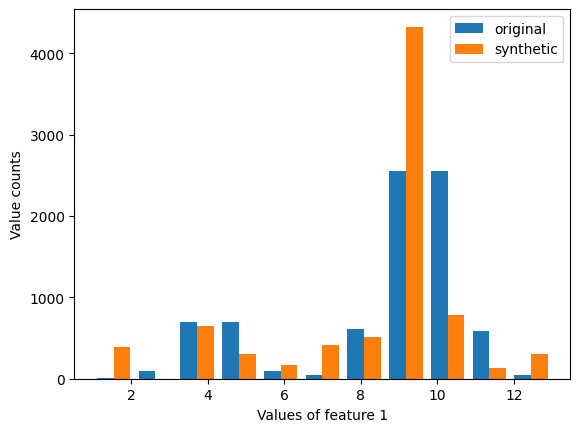

In [41]:
plt.hist((Xy_train['inf_1'], synth_df['inf_1']), label = ('original', 'synthetic'), bins=11)

plt.xlabel('Values of feature 1')
plt.ylabel('Value counts')
plt.legend(loc='upper right')

plt.show()

## PATEGAN
We can try this again with vanilla PATEGAN, although this particular method is specifically geared towards continuous values, so again we expect poor performance.

In [23]:
from opendp.whitenoise.synthesizers.pytorch.pytorch_synthesizer import PytorchDPSynthesizer
from opendp.whitenoise.synthesizers.preprocessors.preprocessing import GeneralTransformer
from opendp.whitenoise.synthesizers.pytorch.nn import PATEGAN

pategan = PytorchDPSynthesizer(PATEGAN(), GeneralTransformer(), 3.0)
pategan.fit(Xy_train, categorical_columns=feature_names + ['class'])
synth_data = pategan.sample(len(Xy_train))

In [24]:
# DP version of dataset
synth_data.describe()

,inf_0,inf_1,inf_2,inf_3,inf_4,inf_5,inf_6,class
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,7.446750,5.295250,7.591000,8.129875,5.417125,6.917625,7.377375,3.435750
std,3.102921,2.621533,2.580514,3.875808,3.005330,2.634380,3.473431,2.183224
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,7.000000,4.000000,5.000000,3.000000,2.000000,6.000000,5.000000,3.000000
50%,7.000000,4.000000,9.000000,8.000000,6.000000,7.000000,8.000000,3.000000
75%,9.000000,8.000000,9.000000,12.000000,7.000000,9.000000,11.000000,3.000000
max,13.000000,12.000000,13.000000,13.000000,12.000000,12.000000,13.000000,9.000000


The statistical match looks ok, but the relative distributions are probably not well correlated.

In [25]:
X_train_dp = synth_data.drop('class', axis = 1)
y_train_dp = synth_data['class']

np.random.seed(seed)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train_dp, y_train_dp)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.06      0.11       200
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       198
           3       0.10      0.92      0.18       200
           4       0.00      0.00      0.00       200
           5       0.00      0.00      0.00       201
           6       0.00      0.00      0.00       198
           7       0.00      0.00      0.00       201
           8       0.04      0.01      0.02       200
           9       0.00      0.00      0.00       202

    accuracy                           0.10      2000
   macro avg       0.08      0.10      0.03      2000
weighted avg       0.08      0.10      0.03      2000

0.099


## DPCTGAN
Usually a QUAILified DPCTGAN is our best bet for ML tasks. In this case, because the dataset is categorical, it is likely that MWEM will outperform DPCTGAN. We will see.

DPCTGAN is a good example of mode collapse in primarily categorical/ordinal datasets

In [42]:
%%time

from opendp.whitenoise.synthesizers.quail import QUAILSynthesizer

from opendp.whitenoise.synthesizers.pytorch.pytorch_synthesizer import PytorchDPSynthesizer
from opendp.whitenoise.synthesizers.preprocessors.preprocessing import GeneralTransformer
from opendp.whitenoise.synthesizers.pytorch.nn.dpctgan import DPCTGAN

synth = QUAILSynthesizer(3.0, PytorchDPSynthesizer, {
    'preprocessor': None,
    'gan': DPCTGAN(loss='wasserstein', batch_size=500, pack=2, sigma=5.0)}, DPLR, {}, 'class')
                        
synth.fit(Xy_train, categorical_columns=['class'], ordinal_columns=feature_names)


(6400, 7)
(6400, 1)
[8 4 6 ... 0 9 7]


/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/diffprivlib/models/logistic_regression.py:222: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


              precision    recall  f1-score   support

           0       0.09      0.13      0.11       149
           1       0.39      0.29      0.33       177
           2       0.53      0.54      0.54       172
           3       0.03      0.07      0.05       160
           4       0.35      0.31      0.33       166
           5       0.92      0.55      0.69       166
           6       0.55      0.28      0.37       149
           7       0.72      0.66      0.69       154
           8       0.76      0.67      0.71       150
           9       0.37      0.36      0.37       157

    accuracy                           0.39      1600
   macro avg       0.47      0.39      0.42      1600
weighted avg       0.47      0.39      0.42      1600

0.38625
Epoch 1, Loss G: -0.0379, Loss D: 0.1232
epsilon is 0.2401550757591162, alpha is 63.0
CPU times: user 1min 33s, sys: 39 s, total: 2min 12s
Wall time: 35.4 s


In [43]:
synth_data = synth.sample(len(Xy_train))

X_train_dp = synth_data.drop('class', axis = 1)
y_train_dp = synth_data['class']

np.random.seed(seed)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train_dp, y_train_dp)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.03      0.04      0.03       200
           1       0.34      0.36      0.35       200
           2       0.50      0.55      0.52       198
           3       0.02      0.04      0.02       200
           4       0.36      0.37      0.37       200
           5       0.75      0.46      0.57       201
           6       0.33      0.07      0.11       198
           7       0.73      0.48      0.58       201
           8       0.66      0.45      0.54       200
           9       0.27      0.28      0.27       202

    accuracy                           0.31      2000
   macro avg       0.40      0.31      0.34      2000
weighted avg       0.40      0.31      0.34      2000

0.31
